# Evaluación de la segmentación

Para la actividad vamos a intentar, mediante el uso de la segmentación, detectar figuras dentro de varios ejemplos de fotografías. Todas son fotografías de estatuas que vamos a intentar detectar.

Para el ejercicio vamos a usar las librerías que nos provee el paquete *scikit-image*.

In [1]:
# Cargamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage import segmentation
from skimage.metrics import adapted_rand_error
from skimage import color
from skimage import measure
from skimage import morphology
from skimage.util import img_as_ubyte

In [2]:
# Cargamos las imagenes y sus respectivas imagenes ground truth
img_1 = plt.imread("Estatua 04.jpg")
img_1_ground_truth = plt.imread("Estatua 04_gt02.jpg")
img_2 = plt.imread("Estatua 07.jpg")
img_2_ground_truth = plt.imread("Estatua 07_gt02.jpg")

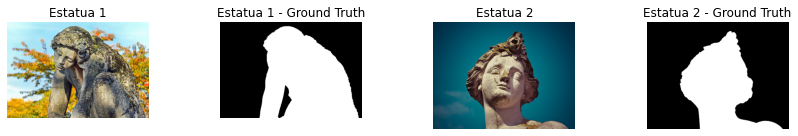

In [3]:
# Mostramos las imagenes
fig, ax = plt.subplots(1, 4, figsize=(12, 2), sharex=True, sharey=True)

ax[0].imshow(img_1)
ax[0].set_title("Estatua 1")
ax[1].imshow(img_1_ground_truth, cmap='gray')
ax[1].set_title('Estatua 1 - Ground Truth')
ax[2].imshow(img_2)
ax[2].set_title('Estatua 2')
ax[3].imshow(img_2_ground_truth, cmap='gray')
ax[3].set_title('Estatua 2 - Ground Truth')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

Vamos a realizar tres tipos de segmentaciones y ver cuales se comportan mejor con estas imágenes

## Segmentación basada en Clustering

In [4]:
meanshift_img_1 = segmentation.quickshift(img_1, kernel_size=10, max_dist=1000, ratio=1)
meanshift_img_2 = segmentation.quickshift(img_2, kernel_size=10, max_dist=1000, ratio=1)

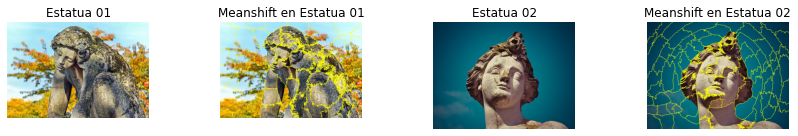

In [5]:
# Mostramos el resultado de la segmentacion
fig, ax = plt.subplots(1, 4, figsize=(12, 2), sharex=True, sharey=True)

ax[0].imshow(img_1)
ax[0].set_title("Estatua 01")
ax[1].imshow(segmentation.mark_boundaries(img_1, meanshift_img_1, mode='thick'))
ax[1].set_title("Meanshift en Estatua 01")
ax[2].imshow(img_2)
ax[2].set_title("Estatua 02")
ax[3].imshow(img_2, cmap=plt.cm.gray)
ax[3].imshow(segmentation.mark_boundaries(img_2, meanshift_img_2, mode='thick'))
ax[3].set_title("Meanshift en Estatua 02")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Como podemos ver en los resultados de la segmentación *meanshift* en las imágenes, se ha producido una sobre-segmentación en ambos casos. Se ha intentado máximizar el tamaño de las regiones pero sigue produciéndose dicho efecto.

El algoritmo parece funcionar mejor en estas imágenes si hacemos que segmente basándose en el color en vez de en la detección de bordes.

## Segmentación basada en Watershed

In [7]:
# Reducimos el ruido
denoised_img_1 = img_as_ubyte(filters.gaussian(color.rgb2gray(img_1), sigma=2))
# Hallamos el gradiente
gradient_img_1 = filters.rank.gradient(denoised_img_1, morphology.disk(2))
# Hallamos las regiones
markers_img_1 = filters.rank.gradient(denoised_img_1, morphology.disk(5)) < 5
markers_img_1 = measure.label(markers_img_1)
# Realizamos la segmentacion
watershed_labels_img_1 = segmentation.watershed(gradient_img_1, markers_img_1)

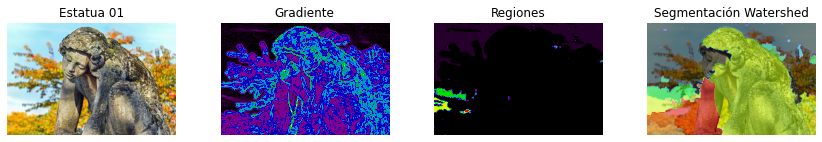

In [8]:
# Mostramos el resultado de la segmentacion en la imagen 01
fig, ax = plt.subplots(1, 4, figsize=(12, 2), sharex=True, sharey=True)

ax[0].imshow(img_1, cmap=plt.cm.gray)
ax[0].set_title("Estatua 01")
ax[1].imshow(gradient_img_1, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Gradiente")
ax[2].imshow(markers_img_1, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Regiones")
ax[3].imshow(img_1, cmap=plt.cm.gray)
ax[3].imshow(watershed_labels_img_1, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmentación Watershed")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Como se puede apreciar en los resultados la segmentación no es del todo correcta ya que confunde parte del fondo con la figura que intentamos detectar y genera más segmentos de los deseados.

Para esta imagen, mejora mucho la segmentación si hacemos que el filtro gaussiano para eliminar ruido sea más potente.

In [9]:
# Reducimos el ruido
denoised_img_2 = img_as_ubyte(filters.gaussian(color.rgb2gray(img_2), sigma=2))
# Hallamos el gradiente
gradient_img_2 = filters.rank.gradient(denoised_img_2, morphology.disk(2))
# Hallamos las regiones
markers_img_2 = filters.rank.gradient(denoised_img_2, morphology.disk(2)) < 5
markers_img_2 = measure.label(markers_img_2)
# Realizamos la segmentacion
watershed_labels_img_2 = segmentation.watershed(gradient_img_2, markers_img_2)

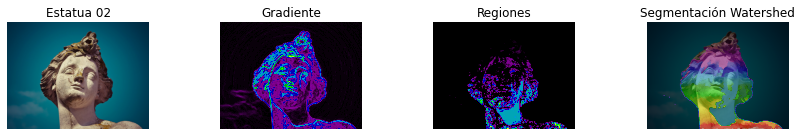

In [10]:
# Mostramos el resultado de la segmentacion en la imagen 02
fig, ax = plt.subplots(1, 4, figsize=(12, 2), sharex=True, sharey=True)

ax[0].imshow(img_2)
ax[0].set_title("Estatua 02")
ax[1].imshow(gradient_img_2, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Gradiente")
ax[2].imshow(markers_img_2, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Regiones")
ax[3].imshow(img_2, cmap=plt.cm.gray)
ax[3].imshow(watershed_labels_img_2, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmentación Watershed")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

El algoritmo *watershed* funciona francamente bien en la detección del contorno de la figura Estatua 2 pero fracasa en el número de segmentos encontrados. 

## Segmentación basada en MST

In [11]:
# Realizamos la segmentación con el algoritmo de Felzenszwalb
felzenszwalb_img_1 = segmentation.felzenszwalb(img_1, scale=1000, sigma=2, min_size=50)
felzenszwalb_img_2 = segmentation.felzenszwalb(img_2, scale=1000, sigma=2, min_size=50)

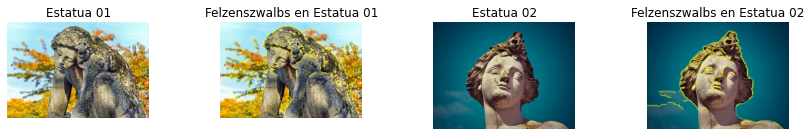

In [12]:
# Mostramos el resultado de la segmentacion
fig, ax = plt.subplots(1, 4, figsize=(12, 2), sharex=True, sharey=True)

ax[0].imshow(img_1)
ax[0].set_title("Estatua 01")
ax[1].imshow(segmentation.mark_boundaries(img_1, felzenszwalb_img_1, mode='thick'))
ax[1].set_title("Felzenszwalbs en Estatua 01")
ax[2].imshow(img_2)
ax[2].set_title("Estatua 02")
ax[3].imshow(img_2, cmap=plt.cm.gray)
ax[3].imshow(segmentation.mark_boundaries(img_2, felzenszwalb_img_2, mode='thick'))
ax[3].set_title("Felzenszwalbs en Estatua 02")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

El algoritmo de Felzenszwalb funciona bastante bien con ambas imágenes. Si bien, es con Estatua 02 con el que realiza un mejor trabajo. A diferencia de los algoritmos probados con anterioridad, la sobre-segmentación es mucho menor en ambas imágenes.

## Evaluación de cada segmentación

Vamos a calcular distintas métricas para analizar como se comporta cada algoritmo en cada imagen, más allá de la evalución visual antes realizada.

In [13]:
# Definimos una funcion para calcular el Intersection over Union
def iou_score(y_tru,Y_pred):
    """
    Taken from:
    https://www.jeremyjordan.me/evaluating-image-segmentation-models/
    """
    intersection = np.logical_and(y_tru,Y_pred)
    union = np.logical_or(y_tru,Y_pred)
    return np.sum(intersection) / np.sum(union)

In [14]:
# Para la segmentacion con clusters en la imagen 1
error_gvf_img_1, precision_gvf_img_1, recall_gvf_img_1 = adapted_rand_error(img_1_ground_truth, meanshift_img_1)
iou_gvf_img_1 = iou_score(img_1_ground_truth, meanshift_img_1)
print(f"Adapted Rand error en Estatua 01: {error_gvf_img_1:.3f}")
print(f"Precision en Estatua 01: {precision_gvf_img_1:.3f}")
print(f"Recall en Estatua 01: {recall_gvf_img_1:.3f}")
print(f"Intersection over Union en Estatua 01: {iou_gvf_img_1:.3f}")

Adapted Rand error en Estatua 01: 0.921
Precision en Estatua 01: 0.041
Recall en Estatua 01: 0.990
Intersection over Union en Estatua 01: 0.461


In [15]:
# Para la segmentacion con clusters en la imagen 2
error_gvf_img_2, precision_gvf_img_2, recall_gvf_img_2 = adapted_rand_error(img_2_ground_truth, meanshift_img_2)
iou_gvf_img_2 = iou_score(img_2_ground_truth, meanshift_img_2)
print(f"Adapted Rand error en Estatua 02: {error_gvf_img_2:.3f}")
print(f"Precision en Estatua 02: {precision_gvf_img_2:.3f}")
print(f"Recall en Estatua 02: {recall_gvf_img_2:.3f}")
print(f"Intersection over Union en Estatua 02: {iou_gvf_img_2:.3f}")

Adapted Rand error en Estatua 02: 0.866
Precision en Estatua 02: 0.072
Recall en Estatua 02: 0.994
Intersection over Union en Estatua 02: 0.329


In [16]:
# Para la segmentacion con watershed en la imagen 1
error_wat_img_1, precision_wat_img_1, recall_wat_img_1 = adapted_rand_error(img_1_ground_truth, watershed_labels_img_1)
iou_wat_img_1 = iou_score(img_1_ground_truth, watershed_labels_img_1)
print(f"Adapted Rand error en Estatua 01:: {error_wat_img_1:.3f}")
print(f"Precision en Estatua 01: {precision_wat_img_1:.3f}")
print(f"Recall en Estatua 01: {recall_wat_img_1:.3f}")
print(f"Intersection over Union en Estatua 01: {iou_wat_img_1:.3f}")

Adapted Rand error en Estatua 01:: 0.195
Precision en Estatua 01: 0.679
Recall en Estatua 01: 0.989
Intersection over Union en Estatua 01: 0.471


In [17]:
# Para la segmentacion con watershed en la imagen 2
error_wat_img_2, precision_wat_img_2, recall_wat_img_2 = adapted_rand_error(img_2_ground_truth, watershed_labels_img_2)
iou_wat_img_2 = iou_score(img_2_ground_truth, watershed_labels_img_2)
print(f"Adapted Rand error en Estatua 02: {error_wat_img_2:.3f}")
print(f"Precision en Estatua 02: {precision_wat_img_2:.3f}")
print(f"Recall en Estatua 02: {recall_wat_img_2:.3f}")
print(f"Intersection over Union en Estatua 02: {iou_wat_img_2:.3f}")

Adapted Rand error en Estatua 02: 0.951
Precision en Estatua 02: 0.025
Recall en Estatua 02: 0.984
Intersection over Union en Estatua 02: 0.325


In [18]:
# Para la segmentacion con Algoritmo de Felzenszwalb en la imagen 1
error_fel_img_1, precision_fel_img_1, recall_fel_img_1 = adapted_rand_error(img_1_ground_truth, felzenszwalb_img_1)
iou_fel_img_1 = iou_score(img_1_ground_truth, felzenszwalb_img_1)
print(f"Adapted Rand error en Estatua 01:: {error_fel_img_1:.3f}")
print(f"Precision en Estatua 01: {precision_fel_img_1:.3f}")
print(f"Recall en Estatua 01: {recall_fel_img_1:.3f}")
print(f"Intersection over Union en Estatua 01: {iou_fel_img_1:.3f}")

Adapted Rand error en Estatua 01:: 0.050
Precision en Estatua 01: 0.913
Recall en Estatua 01: 0.989
Intersection over Union en Estatua 01: 0.594


In [19]:
# Para la segmentacion con Algoritmo de Felzenszwalb en la imagen 2
error_fel_img_2, precision_fel_img_2, recall_fel_img_2 = adapted_rand_error(img_2_ground_truth, felzenszwalb_img_2)
iou_fel_img_2 = iou_score(img_2_ground_truth, felzenszwalb_img_2)
print(f"Adapted Rand error en Estatua 02: {error_fel_img_2:.3f}")
print(f"Precision en Estatua 02: {precision_fel_img_2:.3f}")
print(f"Recall en Estatua 02: {recall_fel_img_2:.3f}")
print(f"Intersection over Union en Estatua 02: {iou_fel_img_2:.3f}")

Adapted Rand error en Estatua 02: 0.080
Precision en Estatua 02: 0.862
Recall en Estatua 02: 0.987
Intersection over Union en Estatua 02: 0.959


Las métricas corroboran nuestras primeras conclusiones: El algoritmo de Felzenszwalb es el que mejor se comporta de los tres evaluados, sobre todo con la imagen Estatua 02 donde además de obtener un alto valor en la precisión y el *recall*, obtenemos un alto valor en el *Intersection over Union*.

Cabe destacar también que la métrica *recall* no parece tener gran relevancia ya que, independientemente del valor que adopten el resto de métricas, los valores son bastante parejos en todos los algoritmos para todas las imágenes. Por lo que deberíamos descartarlo y fijarnos en el resto de valores obtenidos.

Nota: Todas las implementaciones de los algoritmos de segmentación y sus métricas están adaptados de los ejemplos y tutoriales que aparecen en la documentación del paquete de python *scikit-image* (https://scikit-image.org/) salvo que se indique lo contrario.